Link : https://www.kaggle.com/code/sathianpong/3-ways-to-implement-mlp-with-keras

In [41]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import serial

tf.__version__

'2.17.0'

In [42]:
path_to_datasets = "../dataset_publications/MLP/data/data"

# Training data
train_X_val = np.load(f"{path_to_datasets}/X_val.npy")
train_X_signal = train_X_val[::,:-2] # remove frequency at the end to get a good looking signal
train_X_freq = train_X_val[::,-2:] # frequency handled separately
train_X_PCA = np.load(f"{path_to_datasets}/X_train.npy")

train_Y_temp = np.load(f"{path_to_datasets}/y_train.npy")

# Test data
test_X_PCA = np.load(f"{path_to_datasets}/X_test.npy")
test_Y_temp = np.load(f"{path_to_datasets}/y_test.npy")

In [43]:
# Vectorize Y for training and test
# Classes :
# - [0] : 'A' (Atrial premature contraction)
# - [1] : 'L' (Left bundle branch block fluctuation)
# - [2] : 'N' (Normal)
# - [3] : 'R' (Right bundle branch block fluctuation)
# - [4] : 'V' (premature ventricular contraction)

def vectorize_Y(arr):
    mapping = {'A': [1, 0, 0, 0, 0],
               'L': [0, 1, 0, 0, 0],
               'N': [0, 0, 1, 0, 0],
               'R': [0, 0, 0, 1, 0],
               'V': [0, 0, 0, 0, 1]}
    
    res = np.array([mapping[val] for val in arr])
    return res

def devectorize_Y(vectorized_arr):
    mapping = { (1, 0, 0, 0, 0): 'A',
                (0, 1, 0, 0, 0): 'L',
                (0, 0, 1, 0, 0): 'N',
                (0, 0, 0, 1, 0): 'R',
                (0, 0, 0, 0, 1): 'V'}
    res = np.array([mapping[tuple(vec)] for vec in vectorized_arr])
    return res

# Vectorize train and test data
train_Y = vectorize_Y(train_Y_temp)
test_Y = vectorize_Y(test_Y_temp)

print(f"Input shape (PCA) : {train_X_PCA.shape}")
print(f"Output shape : {train_Y.shape}")


Input shape (PCA) : (5000, 10)
Output shape : (5000, 5)


In [44]:
# Save output arrays 
np.save("Y_test_STM32", test_Y)

## Printing dataset samples

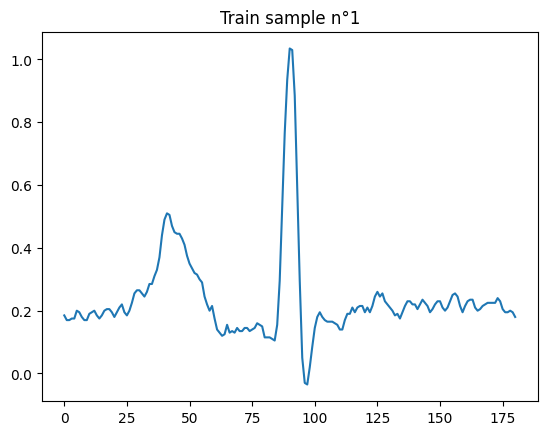

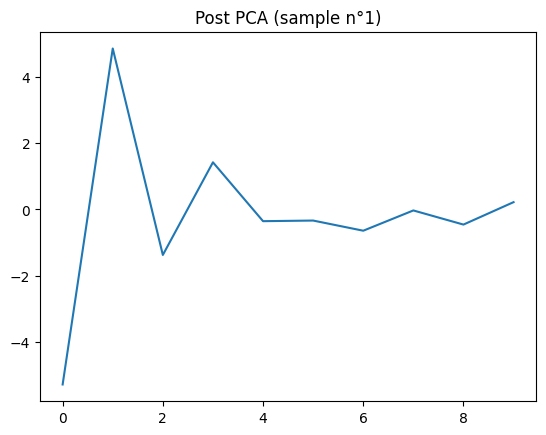

In [45]:
index_shown = 1

plt.plot(np.arange(0, train_X_signal.shape[1]), train_X_signal[index_shown])
plt.title(f"Train sample n°{index_shown}")
plt.show()

plt.plot(np.arange(0, train_X_PCA.shape[1]), train_X_PCA[index_shown])
plt.title(f"Post PCA (sample n°{index_shown})")
plt.show()

In [46]:
# Comptage des différentes classifications

def count_occurrences(arr):
    unique, counts = np.unique(arr, return_counts=True)
    return dict(zip(unique, counts))

count_occurrences(train_Y_temp)

{'A': 971, 'L': 995, 'N': 1038, 'R': 1029, 'V': 967}

# MLP 

In [49]:
# MLP but Sequential

model = model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(train_X_PCA.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax'),
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,029 (4.02 KB)

 Trainable params: 1,029 (4.02 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# MLP Layers - post PCA NN

input_layer = tf.keras.Input(shape=(train_X_PCA.shape[1],))
hidden1 = tf.keras.layers.Dense(64, activation='relu')(input_layer)
# hidden2 = tf.keras.layers.Dense(64, activation='relu')(hidden1)
output_layer = tf.keras.layers.Dense(5, activation='softmax')(hidden1)

model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer, name="MLP-cardIAc-V1")

model.summary()

Model: "MLP-cardIAc-V1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,029 (4.02 KB)

 Trainable params: 1,029 (4.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3909 - loss: 1.6343 - val_accuracy: 0.6660 - val_loss: 1.0948
Epoch 2/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7349 - loss: 1.0046 - val_accuracy: 0.8130 - val_loss: 0.8380
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8243 - loss: 0.7720 - val_accuracy: 0.8300 - val_loss: 0.6955
Epoch 4/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8323 - loss: 0.6594 - val_accuracy: 0.8470 - val_loss: 0.6053
Epoch 5/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8489 - loss: 0.5648 - val_accuracy: 0.8560 - val_loss: 0.5417
Epoch 6/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8622 - loss: 0.4991 - val_accuracy: 0.8670 - val_loss: 0.5031
Epoch 7/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8674 - loss: 0.4577 - val_accuracy: 0.8730 - val_loss: 0.4742
Epoch 8/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8830 - loss: 0.4232 - val_accuracy: 0.8840 - val_loss:

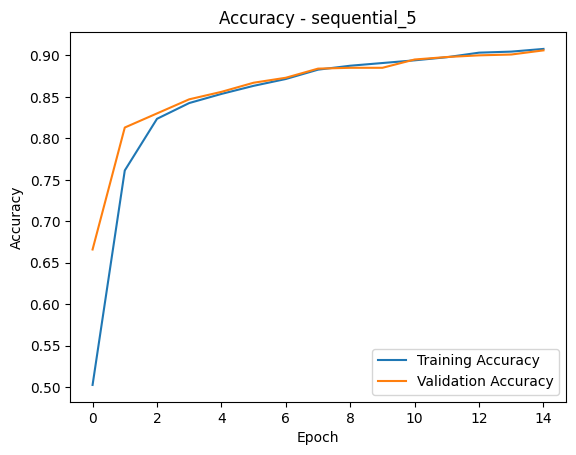

In [50]:
# Compile and train the model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_X_PCA, 
    train_Y, 
    epochs = 15, 
    batch_size=50,
    validation_split=0.2
)

# Plot the accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy - ' + model.name)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [51]:
# Test dataset
loss, acc = model.evaluate(test_X_PCA, test_Y)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9096 - loss: 0.3261


In [53]:
filename = "MLP_cardIAc_seq"

model.save(f"{filename}.keras")
keras_model = tf.keras.models.load_model(f"{filename}.keras")
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()
with open(f"{filename}.tflite", 'wb') as f:     
    f.write(tflite_model)

c:\Users\Lenovo\Documents\Git_repos\cardIAc\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


INFO:tensorflow:Assets written to: C:\Users\Lenovo\AppData\Local\Temp\tmpjmgvdicm\assets


INFO:tensorflow:Assets written to: C:\Users\Lenovo\AppData\Local\Temp\tmpjmgvdicm\assets


Saved artifact at 'C:\Users\Lenovo\AppData\Local\Temp\tmpjmgvdicm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10), dtype=tf.float32, name='input_layer_10')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2000011735696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2000011733968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1999920115600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1999920109456: TensorSpec(shape=(), dtype=tf.resource, name=None)
